# Title
**Author**:  Greg Slater <br>
**Date**:  24th September 2024 <br>
**Dataset Scope**: `dataset` <br>
**Report Type**: Ad-hoc analysis <br>

## Purpose


In [139]:
import pandas as pd
import geopandas as gpd
import shapely
import numpy as np
import os
import urllib
# from sqlite_query_functions import DatasetSqlite
from datetime import datetime
import json
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 100)

td = datetime.today().strftime('%Y-%m-%d')
data_dir = "../../data/REPORT_NAME/"
os.makedirs(data_dir, exist_ok=True)
# fn = os.path.join(data_dir, f"FILENAME_{td}.csv")


## Functions

In [1]:
def datasette_query(db, sql_string):
    params = urllib.parse.urlencode({
        "sql": sql_string,
        "_size": "max"
        })
    url = f"https://datasette.planning.data.gov.uk/{db}.csv?{params}"
    df = pd.read_csv(url)
    return df

## Data Import

In [77]:
q = """
    SELECT organisation, parameters, passed, message, details
    FROM expectation
    WHERE 1=1
        AND name = 'Check number of entities inside the local planning authority boundary matches the manual count' 
    """

exp_ca_check = datasette_query("digital-land", q)
exp_ca_check["expected"] = [json.loads(v)["expected"] for v in exp_ca_check["parameters"]]
print(len(exp_ca_check))

329


In [56]:
q = """
    SELECT dataset, organisation, parameters, passed, message, details
    FROM expectation
    WHERE 1=1
        AND name = 'Check no entities are outside of the local planning authority boundary'
        and message not like '%error%'
    """

exp_bound_check = datasette_query("digital-land", q)
exp_bound_check["actual"] = [json.loads(v)["actual"] for v in exp_bound_check["details"]]
print(len(exp_bound_check))

691


In [73]:
q = """
    SELECT dataset, organisation
    FROM provision
    WHERE dataset = "conservation-area"
    AND end_date = ""
    """

prov_ca = datasette_query("digital-land", q)
print(len(prov_ca))

307


In [88]:
q = """
    select entity as organisation_entity, name as org_name, organisation
        from organisation
        where end_date = ""
    """

lookup_org = datasette_query("digital-land", q)
lookup_org["organisation_entity"] = lookup_org["organisation_entity"].astype(int)
print(len(lookup_org))

382


In [93]:
def get_pdp_dataset(dataset, geometry_field = "geometry", crs_out=4326, underscore_cols=True):

    df = pd.read_csv(
        f"https://files.planning.data.gov.uk/dataset/{dataset}.csv", 
        dtype = {"entity": pd.Int64Dtype(), "organisation-entity": pd.Int64Dtype()}
        )
    
    df.columns = [x.replace("-", "_") for x in df.columns]

    df_valid_geom = df[df[geometry_field].notnull()].copy()

    # load geometry and create GDF
    df_valid_geom[geometry_field] = df_valid_geom[geometry_field].apply(shapely.wkt.loads)
    gdf = gpd.GeoDataFrame(df_valid_geom, geometry = geometry_field)

    # Transform to ESPG:27700 for more interpretable area units
    gdf.set_crs(epsg=4326, inplace=True)
    gdf.to_crs(epsg=crs_out, inplace=True)

    return gdf

ca_df = get_pdp_dataset("conservation-area", "point")
print(len(ca_df))

ca_df.drop("organisation", axis=1, inplace=True)

ca_df = ca_df.merge(
    lookup_org,
    how = "left",
    on = "organisation_entity"
)
print(len(ca_df))

8636
8636


# Analysis
## Out of bounds

* How many LPAs have provided entities that fall outside of their boundary?
* What is the total number of datasets affected?
* What is the total number of entities that are out of bounds across all LPAs?

In [152]:
exp_bound_check_fail = exp_bound_check[exp_bound_check["passed"] == False]

n_fail_lpas = len(exp_bound_check_fail["organisation"].drop_duplicates())
n_fail_ents = exp_bound_check_fail["actual"].sum()

print(f"How many LPAs have provided entities that fall outside of their boundary: {n_fail_lpas}")
print()
print(f"What is the total number of entities that are out of bounds across all LPAs: {n_fail_ents}")
print()
print("Worst offenders: ")
exp_bound_check_fail.groupby(["organisation"], as_index=False).agg(
    n_entities = ("actual", "sum")
).sort_values("n_entities", ascending=False).head(10)

How many LPAs have provided entities that fall outside of their boundary: 69

What is the total number of entities that are out of bounds across all LPAs: 548

Worst offenders: 


,organisation,n_entities
7,local-authority:CAN,95
65,local-authority:WOK,77
22,local-authority:GRY,66
58,local-authority:TEW,52
28,local-authority:KIN,34
17,local-authority:EHA,25
59,local-authority:TWH,20
54,local-authority:STT,17
26,local-authority:HOR,12
46,local-authority:SAW,10


In [153]:
exp_bound_check_counts_dataset = exp_bound_check.groupby(["dataset", "passed"], as_index=False).agg(
    n_lpas = ("organisation", "count"),
    n_entities = ("actual", "sum")
)

### How many datasets affected?

All datasets have some LPAs with entities out of bounds, with tree the worst core ODP dataset. BFL is so much higher because we have more data.

In [165]:
exp_bound_check_counts_dataset[exp_bound_check_counts_dataset["passed"] == False]

,dataset,passed,n_lpas,n_entities
0,article-4-direction-area,False,3,18
2,brownfield-land,False,51,315
4,conservation-area,False,2,35
6,listed-building-outline,False,7,67
8,tree,False,9,76
10,tree-preservation-zone,False,8,37


## Conservation area count comparison

Of all the LPAs who have provided data and who we have an 'expected' count for, how many of those have a mismatch between the 'actual' and 'expected' count? (This should only consider entities provided by that LPA, and consider all entities for that dataset from that LPA regardless of whether the entity is inside their boundary)

Of all the LPAs with a discrepancy, how many have:

    Fewer entities than expected?

    More entities than expected?

What's the distribution of discrepancies in actual vs expected counts? e.g. how many LPAs have provided 5+ more entities than expected.

Of all the LPAs who haven't provided data, how many do we have an 'expected' count for?

In [ ]:
ca_org_count = ca_df.groupby(["organisation"], as_index=False).agg(
    n_entities = ("entity", "count")
)

In [150]:
# join actual counts by org (not geog) to provision table
exp_ca_check_org_actual = prov_ca.merge(
    exp_ca_check,
    how = "left",
    on = "organisation"
    ).merge(
        ca_org_count,
        how = "left",
        on = "organisation"
    )

exp_ca_check_org_actual["delta"] = exp_ca_check_org_actual["expected"] - exp_ca_check_org_actual["n_entities"]
exp_ca_check_org_actual["expected_available"] = np.where(exp_ca_check_org_actual["expected"] != 0, True, False)
exp_ca_check_org_actual["lpa_provision"] = np.where(exp_ca_check_org_actual["n_entities"].notnull(), True, False)

# lpas with provision
exp_ca_check_provs = exp_ca_check_org_actual[exp_ca_check_org_actual["lpa_provision"] == True].copy()

exp_ca_check_provs["bins"] = np.select(
    [
        (exp_ca_check_provs["delta"] == 0).astype(bool),
        (exp_ca_check_provs["delta"] < 0).astype(bool),
        (exp_ca_check_provs["delta"] > 0).astype(bool)
    ],
    [
        "Match" , "Fewer than expected", "More than expected"
    ], default = "pass"
)

### Breakdown of LPAs with discrepancy

In [151]:
exp_ca_check_provs.groupby("bins", as_index = False).size()

,bins,size
0,Fewer than expected,17
1,Match,25
2,More than expected,8


### Distribution of LPAs with discrepancy

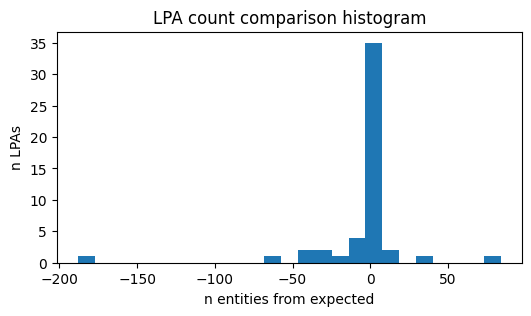

In [166]:
exp_ca_check_provs["delta"].plot.hist(bins = 25, figsize = (6, 3))

plt.xlabel('n entities from expected')
plt.ylabel('n LPAs')
plt.title('LPA count comparison histogram')
plt.show()

### How many LPAs do we have expected counts for?
We have an expected count for 250 out of the 257 LPAs who haven't provided data

In [148]:
exp_ca_check_org_actual.groupby(["expected_available", "lpa_provision"], as_index=False).size()

,expected_available,lpa_provision,size
0,False,False,7
1,False,True,1
2,True,False,250
3,True,True,49


#### Look at LPAs without an expected count

In [149]:
exp_ca_check_org_actual[exp_ca_check_org_actual["expected_available"] == False]

,dataset,organisation,parameters,passed,message,details,expected,n_entities,delta,expected_available,lpa_provision
0,conservation-area,development-corporation:Q117149370,"{""lpa"": """", ""expected"": 0, ""geometric_relation...",False,An error occurred when retrieving lpa geometry...,{},0,<NA>,<NA>,False,False
1,conservation-area,development-corporation:Q124604981,"{""lpa"": """", ""expected"": 0, ""geometric_relation...",False,An error occurred when retrieving lpa geometry...,{},0,<NA>,<NA>,False,False
4,conservation-area,development-corporation:Q72463795,"{""lpa"": ""E60000328"", ""expected"": 0, ""geometric...",True,there were 0 entities found,"{""actual"": 0, ""expected"": 0, ""entities"": []}",0,<NA>,<NA>,False,False
40,conservation-area,local-authority:BUC,"{""lpa"": ""E60000331"", ""expected"": 0, ""geometric...",False,there were 360 entities found,"{""actual"": 360, ""expected"": 0, ""entities"": [44...",0,188,-188,False,True
59,conservation-area,local-authority:COL,"{""lpa"": ""E60000159"", ""expected"": 0, ""geometric...",False,there were 22 entities found,"{""actual"": 22, ""expected"": 0, ""entities"": [440...",0,<NA>,<NA>,False,False
179,conservation-area,local-authority:NYUA,"{""lpa"": ""E60000336"", ""expected"": 0, ""geometric...",False,there were 228 entities found,"{""actual"": 228, ""expected"": 0, ""entities"": [44...",0,<NA>,<NA>,False,False
240,conservation-area,local-authority:SUA,"{""lpa"": ""E60000337"", ""expected"": 0, ""geometric...",False,there were 179 entities found,"{""actual"": 179, ""expected"": 0, ""entities"": [44...",0,<NA>,<NA>,False,False
305,conservation-area,national-park-authority:Q72617890,"{""lpa"": ""E60000323"", ""expected"": 0, ""geometric...",False,there were 1 entities found,"{""actual"": 1, ""expected"": 0, ""entities"": [4400...",0,<NA>,<NA>,False,False


## Alternative source mismatched entities:

How many LPAs have Historic England entities in their boundary that don't match to the LPA's submitted entities?

What's the distribution of these entities?

* Number of LPAs with 1-2 mismatched entities
* Number of LPAs with 3-5 mismatched entities
* Number of LPAs with more than 5 mismatched entities


Note - as a bit of a shortcut I'm grabbing some data from another report here. It's not 100% what you've asked; it's identifying LPA entities which overlap partially with an HE entity, but may not count where for instance there are HE entities which are completely separate from any LPA ones.

In [162]:
dupe_checks = pd.read_csv("issues_type_2b-between_org-HE_to_LPA.csv")

mismatches = dupe_checks[
    (dupe_checks["action"] == "investigate") &
    (dupe_checks["intersection_type"] != "edge intersection")
]

#### Breakdown of the intersection types between LPA and Historic England entities

In [163]:
mismatches.groupby(["issue_type", "intersection_type", "action", "priority", "multiple_issues", "org_overlap_type"]).size()

issue_type                                       intersection_type     action       priority  multiple_issues  org_overlap_type                  
Between organisations - Historic England to LPA  > 90% combined match  investigate  high      True             LPA and HE mostly cover each other      7
                                                 > 90% single match    investigate  medium    False            LPA mostly covered by HE               19
                                                                                                               LPA mostly covers HE                   19
                                                                                              True             LPA mostly covered by HE              112
                                                                                                               LPA mostly covers HE                   15
                                                 unclassified          investigate  low  

#### Count of issues per LPA

Note, this isn't a strict count of entities, it's a count of the number of issues - one LPA entity could overlap with multiple HE entities, in which case it's counted multiple times as separate issues.

In [164]:
mismatches.groupby("organisation_name_1").size().sort_values(ascending = False)

organisation_name_1
Maldon District Council                                52
St Albans City and District Council                    27
Mole Valley District Council                           13
North Dorset District Council                          10
Great Yarmouth Borough Council                          9
East Hampshire District Council                         8
Waverley Borough Council                                7
Cambridge City Council                                  7
Chichester District Council                             6
Ministry of Housing, Communities & Local Government     5
North Somerset Council                                  4
Cornwall Council                                        3
St Helens Council                                       3
Calderdale Metropolitan Borough Council                 3
Buckinghamshire Council                                 3
Purbeck District Council                                2
Vale of White Horse District Council                